# Example Analysis of MDB Water Depth
The purpose of this notebook is to help new users of the Murray Darling Basin Water Depth product get started.

First, let us define where flood water depth product sits on disk

In [2]:
flood_water_depth_prefix = "FWDET/v3.6/4326/"

Now let us import libraries that we might need to run the code

In [54]:
import s3fs
import rioxarray
import xarray
import numpy 
import pandas
import matplotlib.pyplot as plt

In our example, we will select a subset of the complete water depth product. The 7 scenes from November 2021 are a good place to start because the MDB has seen plenty of rain, and since Landsat 9 was flying during this period, there were a range of good images that informed the maximum flood extent product. If you want to select a different date range (or the full date range), then alter the indices `full_date_range[203:210]`.

In [66]:
two_month_start = pandas.date_range('1988-01-01', '2022-12-31', freq='2MS')
full_date_range = [f"{x:%Y_%m}" for x in two_month_start]
recent_subset_bimonths = full_date_range[203:210] # recent period with ls9 data
input_names= {recent_subset_bimonth:"{0}FwDET_v3_TPS_{1}.tif".format(flood_water_depth_prefix, recent_subset_bimonth) 
              for recent_subset_bimonth in recent_subset_bimonths}
print(recent_subset_bimonths)

['2021_11', '2022_01', '2022_03', '2022_05', '2022_07', '2022_09', '2022_11']


This code selects a loads a spatial subset of the output - `22000:23000,32800:33800` - and merges it into a single xarray.dataarray. The window is somewhere near Macquarie Marshes. I have selected by pixel range to ensure there are exactly 1000x1000 pixels in the window. It would also be possible to select through coordinates. There are two datacubes produced (`rds_merge` and `rds_merge_with_nan`) - one with dry land as zero, and one with dry land as nan. Dry land as zero is better for numerical analysis, but dry land as nan looks better in the maps. 

In [11]:
rds_by_bimonth = {bimonth:rioxarray.open_rasterio(input_name) for bimonth, input_name in input_names.items()}

windowed_rds = {bimonth:rds[0,22000:23000,32800:33800].astype("int") for bimonth, rds in rds_by_bimonth.items()}
windowed_rds_with_nan = {bimonth:xarray.where(rds==0, numpy.nan,rds)for bimonth, rds in windowed_rds.items()}

timed_windowed_rds = [rds.assign_coords({'time': bimonth}).expand_dims("time") for bimonth, rds in windowed_rds.items()]
timed_windowed_rds_with_nan = [rds.assign_coords({'time': bimonth}).expand_dims("time") for bimonth, rds in windowed_rds_with_nan.items()]

rds_merge = xarray.combine_by_coords(timed_windowed_rds)
rds_merge_with_nan = xarray.combine_by_coords(timed_windowed_rds_with_nan)

Now lets plot the 7 images using xarray and matplotlib.pyplot as a FacetGrid

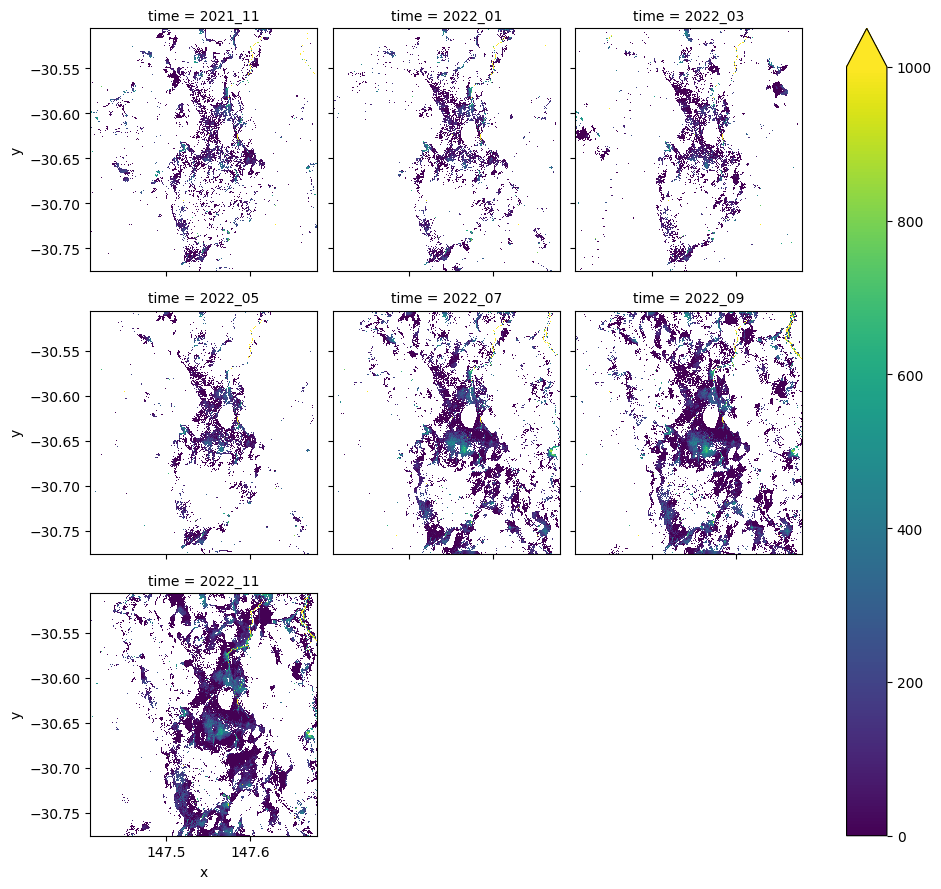

In [68]:
x=rds_merge_with_nan.plot.imshow(col='time',vmin=0, vmax=1000,col_wrap=3)

# Simple statistics
Now let us calculate the median water depth from the seven images. Xarray provides us with tools to work with multidimensional data (e.g. datacubes). In this case the median function can calculate the median through the dimension time.

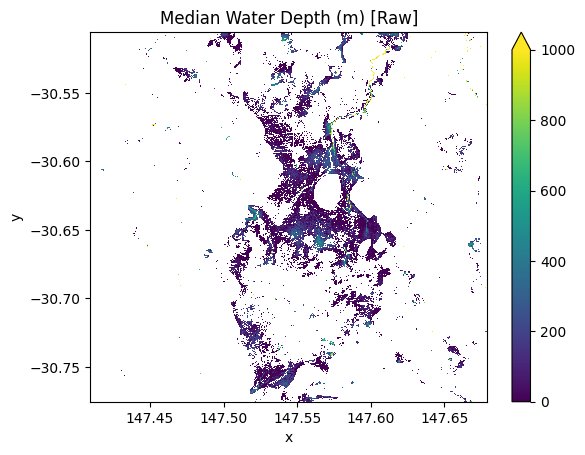

In [57]:
median_zero = rds_merge.median(dim='time')
xarray.where(median_zero==0, numpy.nan,median_zero).plot.imshow(vmin=0, vmax=1000)
x= plt.title("Median Water Depth (m) [Raw]")

# Temporal statistics
Now let us estimate the total area and volume inundated through time. Since the imagery is produced in geographic coordinates, we need a conversion factor to translate from degrees to meters. We use a simple approximation that assumes the world is a sphere (rather than an ellipsoid).

In [69]:
# Approximate the surface area / volume of water in the image (assuming sphere)
res = 0.0002698 # cell size in degrees
lat_m =  res * 111.32*1000
lon_m = res * 40075 *1000* 0.866 / 360 
print ("Approximate size of cells {0} m x {1} m".format(lat_m,lon_m))

Approximate size of cells 30.034136 m x 26.009431972222217 m


Now let us estimate the total area using xarray's where and sum functions. We assign a value of 1 for any inundated cells and a value of 0 for any dry cells. Then we sum the number of cells. In this case, when we do the sum, we want to collapse the spatial dimensions (x and y) and leave the time dimension.

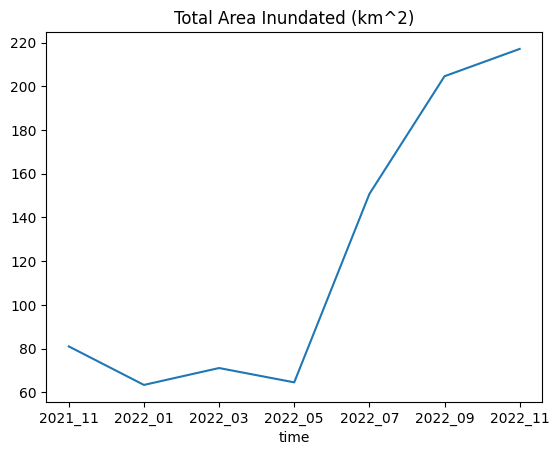

In [70]:
rds_wet = xarray.where(rds_merge>0,1,0)
total_area_km2 = rds_wet.sum(dim=['x','y'])*lat_m*lon_m/1e6
total_area_km2.plot()
x= plt.title("Total Area Inundated (km^2)")

Now let us approximate the total volume across the 1000 x 1000 pixels we have seen above. Trivially, volume is the sum of all the depths. We do need to be a little careful with the units to ensure that we get something sensible.

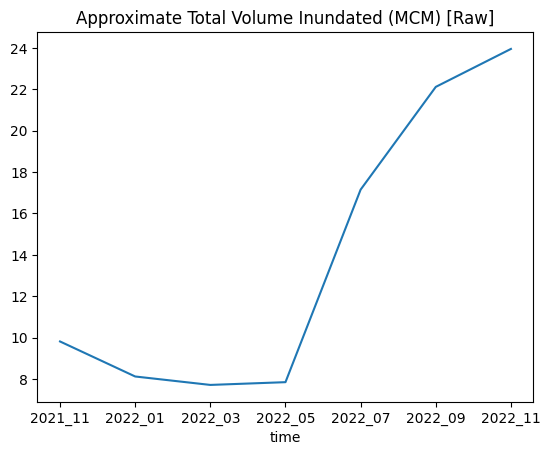

In [61]:
volume_MCM = (rds_merge.sum(dim=['x','y'])/1e3*lat_m*lon_m)/1e6
volume_MCM.plot() # sum of pixels mm
x= plt.title("Approximate Total Volume Inundated (MCM) [Raw]")

However, we know that FwDET for the MDB underestimates the depth of water by around 0.3 m. Since all the areas where inundation was observed have a value>0, the bias is something that we can correct for. In this case, we add 340mm to every cell observed as wet. As you can see, it makes a big difference to the estimated volume.

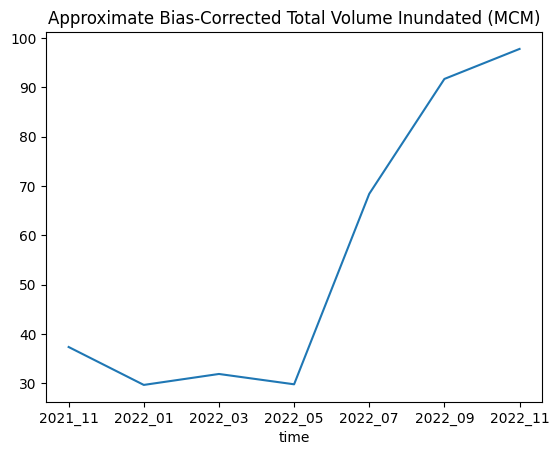

In [63]:
volume_bias_corrected_MCM = (((rds_merge+rds_wet*340).sum(dim=['x','y']))/1e3*lat_m*lon_m)/1e6
volume_bias_corrected_MCM.plot() # sum of pixels mm
x= plt.title("Approximate Bias-Corrected Total Volume Inundated (MCM)")

Notes:
- If you are doing anything volumetric, keep an eye out for cloud.
- Also make note of any areas with estimated bathymetry such as lakes and dams. It may make sense to substitute more accurate information for these areas.  